In [1]:
from pymc import *
import pymc as pm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#reading data
data = pd.read_csv('MMM_test_data.csv',sep=',',parse_dates=['start_of_week'],index_col='start_of_week')
X = data.drop(columns=['revenue'])
y = data['revenue']
y = y.to_frame()
t_orig = y.index


In [4]:
import pytensor.tensor as at

In [5]:
#delayed adstock function
def adstock_delayed(x, alpha, theta, max_dur=13):
    '''
    x: spend vector for specific channel
    alpha,theta: parameters of the weight function of the adstock transformation
    max_dur: maximum time span (in weeks) in which carry over effect can take place
    '''
    delayed_vector = at.as_tensor_variable([at.power(alpha,at.power(i-theta,2)) for i in range(max_dur)])
    x_matrix = at.stack(
        [at.concatenate([at.zeros(i),x[:x.shape[0]-i]]) for i in range(max_dur)]
    )
    return at.dot(delayed_vector/at.sum(delayed_vector),x_matrix)

In [6]:
import pymc as pm
import arviz as az

In [7]:
# scaling and normalization of data

def minmaxscaler(series):
    """Scale between 0 and 1 a pandas series"""
    return (series - series.min()) / (series.max() - series.min())

#scaling the time between 0 and 1
t = minmaxscaler(y.index)
t = t.to_frame()

#independent variables transformation
independent_v = ["spend_channel_1","spend_channel_2","spend_channel_3","spend_channel_4",
                 "spend_channel_5","spend_channel_6","spend_channel_7"]

data_transformed = data.copy()
for c in independent_v:
    original = X[c]
    transformed = minmaxscaler(original)
    data_transformed[c] = transformed
    
#dependent variable transformation
dependent_transformation = None
original = data_transformed["revenue"].values
data_transformed["revenue"] = original / 100_000

#reading data
X = data_transformed.drop(columns=['revenue'])
y = data_transformed['revenue']
y = y.to_frame()


<AxesSubplot:xlabel='start_of_week', ylabel='revenue'>

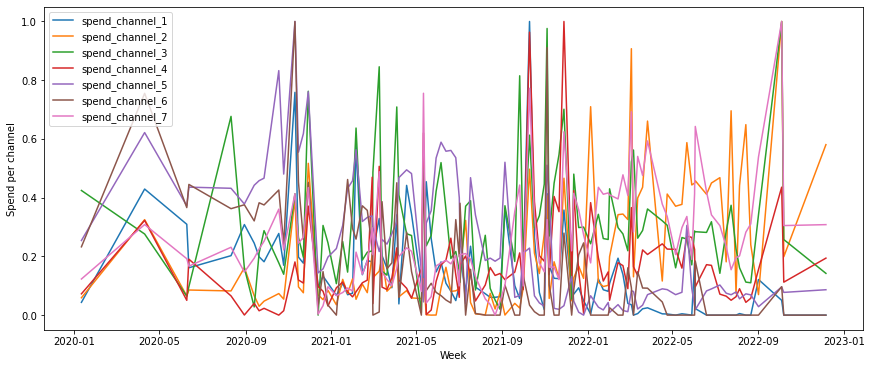

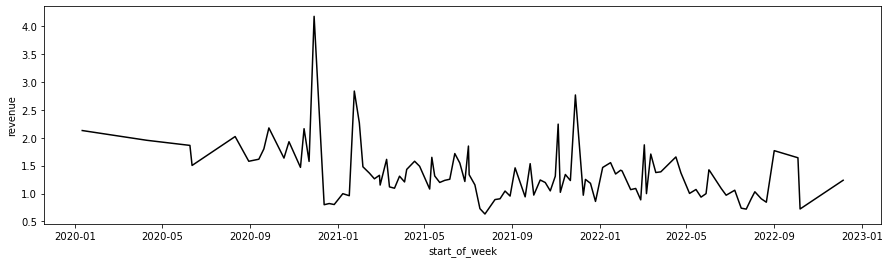

In [8]:
# plots channel spend in time
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(12, 5),
    sharex=True,
    sharey=False,
    layout="constrained"
)
for i,c in enumerate(X.columns):
    sg = sns.lineplot(x="start_of_week", y=c, data=X, ax=ax,label=c)
sg.set(xlabel ="Week", ylabel = "Spend per channel")
# plot revenue in time
fig2, ax2 = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(15, 4)
)  
sns.lineplot(x="start_of_week", y="revenue", data=y, color="black",ax=ax2)

In [9]:
RANDOM_SEED = 49 #in order to be able to replicate the results


# The carryover model. It does not include shape effects.
with pm.Model() as mmm:
    #prior information in the form of distributions

    intercept = pm.Normal("intercept", np.mean(y.values.flatten()), 2)
    trend = pm.Normal('trend',0,2)
    alpha = pm.Beta('alpha', 3, 3, shape=X.shape[1])
    theta = pm.Uniform('theta',0,12,shape=X.shape[1])
    noise=pm.HalfNormal('noise',1)
   
    
    all_media_effect = []
    # calculating contribution for each channel
    for i,ch in enumerate(X.columns):
        Xchannel = X[ch].values
        media_effect = adstock_delayed(x=Xchannel, alpha=alpha[i],theta=theta[i])
        all_media_effect.append(media_effect)
    
    lin = intercept + trend * t.values.flatten()
    mu = lin + sum(all_media_effect)
    
    #likelihood sampling distribution 
    y_hat= pm.Normal('y_hat',mu=mu,sigma=noise,observed=y.values.flatten())
    
    idata = pm.sample_prior_predictive(samples=50,random_seed=RANDOM_SEED)
    
    
    

Sampling: [alpha, intercept, noise, theta, trend, y_hat]


In [10]:
#NUTS sampling
#creating inference data object 

with mmm:
    idata.extend(pm.sample(1000, tune=2000, random_seed=RANDOM_SEED))

/home/gmeneses/local/anaconda3/envs/pygmt/lib/python3.10/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains i

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 52 seconds.


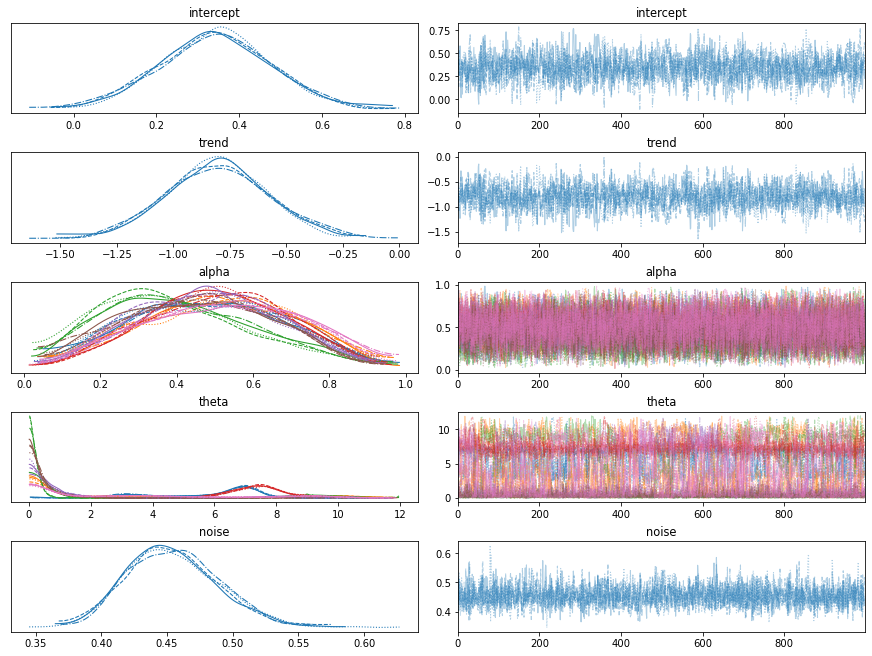

In [11]:
#checking posteriors

#summary
az.summary(idata,round_to=2)

#plot posteriors
import arviz as az
axes = az.plot_trace(
    data=idata,
    compact=True,
    backend_kwargs={
        "figsize": (12, 9),
        "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()



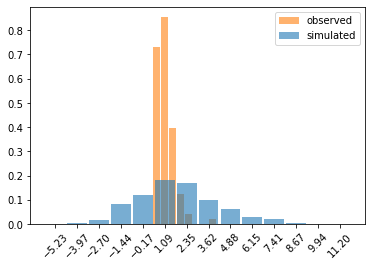

In [12]:
#cheking the priors
az.plot_dist(
    y.values,
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    idata.prior_predictive["y_hat"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated",
)
plt.xticks(rotation=45);


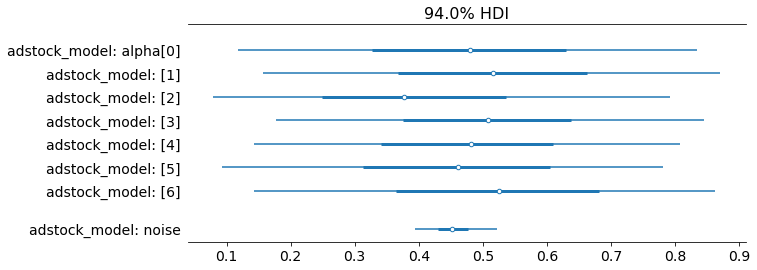

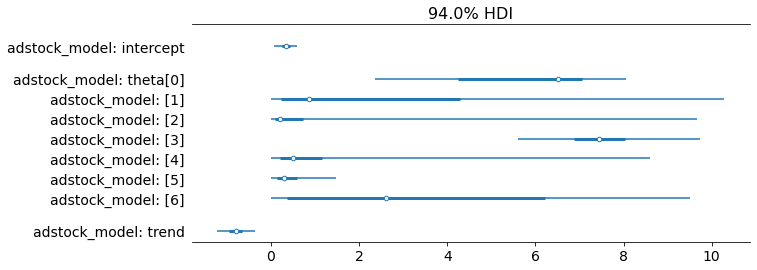

In [13]:
#HDI posterior statistics
axes = az.plot_forest(
    data=[idata],
    model_names=["adstock_model"],
    var_names=[ "alpha",  "noise"],
    combined=True,
    figsize=(10, 4),
);
axes = az.plot_forest(
    data=[idata],
    model_names=["adstock_model"],
    var_names=["intercept", "theta","trend"],
    combined=True,
    figsize=(10, 4),
);

In [14]:
#sampling data from posterior
with mmm:
    pm.sample_posterior_predictive(
        idata, extend_inferencedata=True, random_seed=RANDOM_SEED
    )


    

Sampling: [y_hat]


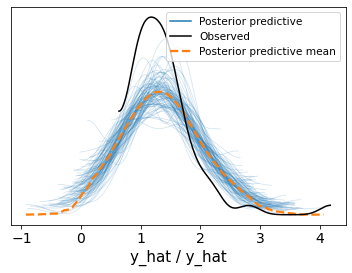

In [15]:
#comparison posterior predicted density vs. observation density
az.plot_ppc(idata,num_pp_samples=100);

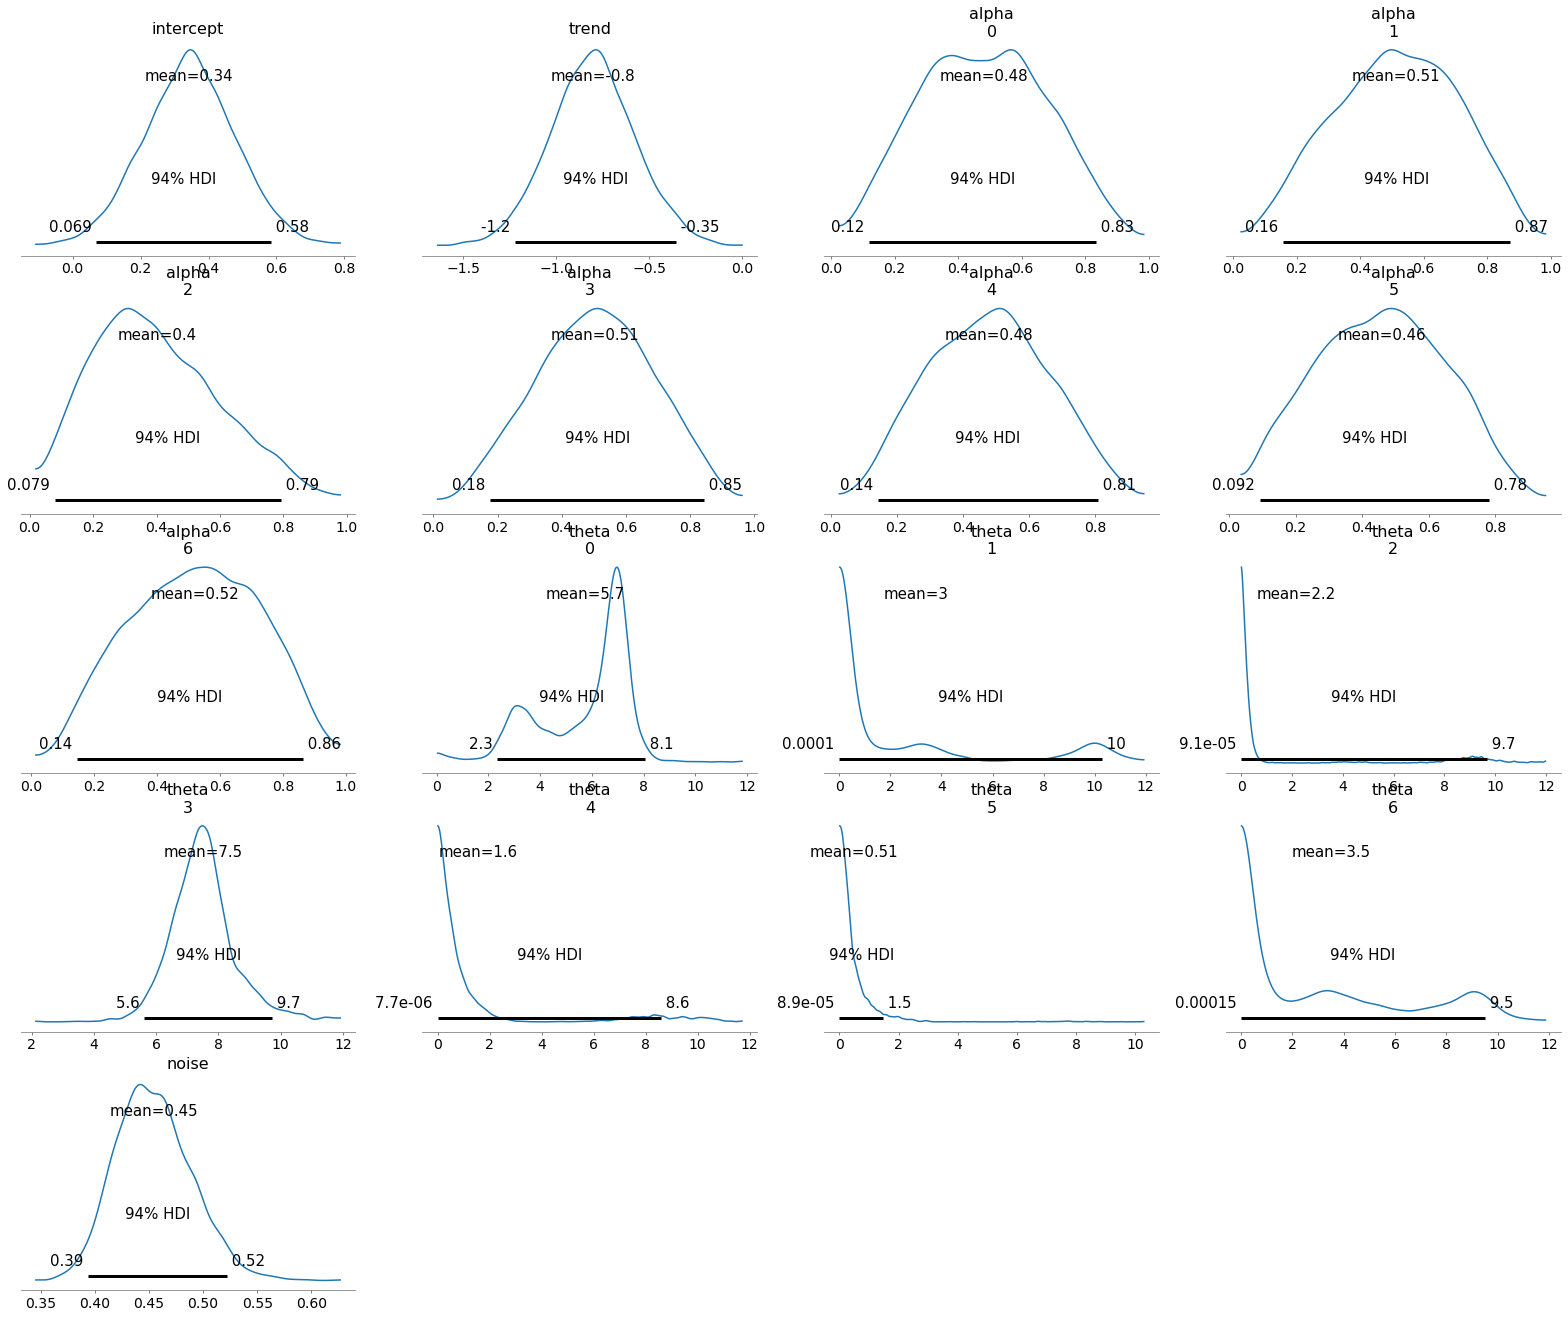

In [16]:
# a look to every parameter individually
az.plot_posterior(data=idata);

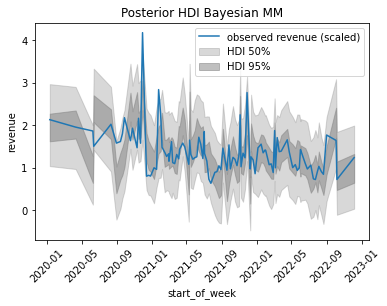

In [17]:
# Posterior HDI vs. observations
fig, ax = plt.subplots()
sns.lineplot(
    x=t_orig, y="revenue", data=data_transformed, color="C0", label="observed revenue (scaled)", ax=ax
    
)

az.plot_hdi(
    #x=t.values.flatten(),
    x=t_orig,
    y=idata.posterior_predictive["y_hat"],
    hdi_prob=0.95,
    color="gray",
    
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.3},
    
    ax=ax,
)
az.plot_hdi(
    #x=t.values.flatten(),
    x=t_orig,
    y=idata.posterior_predictive["y_hat"],
    hdi_prob=0.5,
    color="gray",
    
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.5},
    ax=ax,
)

ax.legend(loc="upper right")
ax.set(title="Posterior HDI Bayesian MM")
plt.xticks(rotation=45);